## Setup Environment

In [ ]:
# Install specific libraries
! pip install transformers
! pip install pycaret

In [1]:
import torch
print(torch.__version__)            # doit afficher 2.5.1
print(torch.cuda.is_available())    # True si GPU détecté
print(torch.cuda.get_device_name(0))# Nom de ton GPU


2.5.1
True
NVIDIA GeForce RTX 4070 Laptop GPU


In [3]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
#from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [4]:
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [5]:
# Set Working Directory - if working on Google Drive
#%cd /content/drive/MyDrive/1_LiveProjects/Project11_FakeNewsDetection

# # Set Working Directory - if working on Local Machine
import os
os.chdir(r'C:\Users\OMEN\FAKENEWS')

## Load Dataset

In [7]:
import pandas as pd

# Load Dataset
true_data = pd.read_csv('True.csv')
fake_data = pd.read_csv('Fake.csv')

# Generate labels True/Fake under new Target Column
true_data['Target'] = 'True'
fake_data['Target'] = 'Fake'

# Merge true_data and fake_data by random mixing
data = pd.concat([true_data, fake_data], ignore_index=True).sample(frac=1).reset_index(drop=True)

# See how the data looks like
print(data.shape)
data.head()


(44898, 5)


,title,text,subject,date,Target
0,Germany Displacing Residents To Make Way For S...,The Obama regime has already set the ball in m...,politics,"Sep 27, 2015",Fake
1,These 10 Seconds Of Sarah Palin’s INSANE Trum...,Pretty much all of Sarah Palin s endorsement o...,News,"January 20, 2016",Fake
2,"France's Macron, unions seek upper hand in str...",PARIS (Reuters) - Emmanuel Macron may have won...,worldnews,"October 8, 2017",True
3,"Stolen Valor: GOP Senator Disgracefully Lies,...",Senator Mark Kirk (R-IL) has been caught red-h...,News,"September 21, 2016",Fake
4,MINNESOTA CHURCH Places 1800 “Blessed Ramadan”...,Here s the truth about the Somali Muslim popul...,left-news,"Jul 1, 2016",Fake


In [ ]:
# Convert Target column from strings to numeric labels (True=0, Fake=1)
data['label'] = data['Target'].map({'True': 0, 'Fake': 1})


In [30]:
data.head()

,title,text,subject,date,Target,label
0,Germany Displacing Residents To Make Way For S...,The Obama regime has already set the ball in m...,politics,"Sep 27, 2015",Fake,1
1,These 10 Seconds Of Sarah Palin’s INSANE Trum...,Pretty much all of Sarah Palin s endorsement o...,News,"January 20, 2016",Fake,1
2,"France's Macron, unions seek upper hand in str...",PARIS (Reuters) - Emmanuel Macron may have won...,worldnews,"October 8, 2017",True,0
3,"Stolen Valor: GOP Senator Disgracefully Lies,...",Senator Mark Kirk (R-IL) has been caught red-h...,News,"September 21, 2016",Fake,1
4,MINNESOTA CHURCH Places 1800 “Blessed Ramadan”...,Here s the truth about the Somali Muslim popul...,left-news,"Jul 1, 2016",Fake,1


([<matplotlib.patches.Wedge at 0x2382b9fb550>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

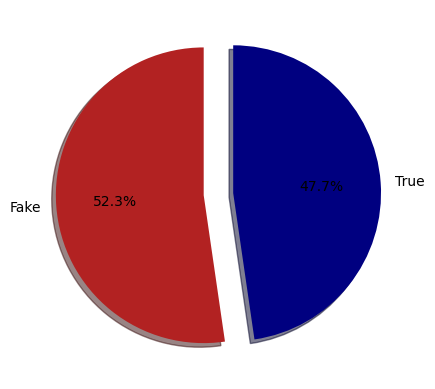

In [31]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [32]:
# Train-Validation-Test set split into 70:15:15 ratio
# Train-Temp split
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
# Validation-Test split
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [33]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer

# Constants
MAX_LENGTH = 15   # max title length
BATCH_SIZE = 32   # batch size

In [34]:
# Load BERT model and tokenizer via HuggingFace Transformers
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


### Prepare Input Data

Text(0, 0.5, 'Number of texts')

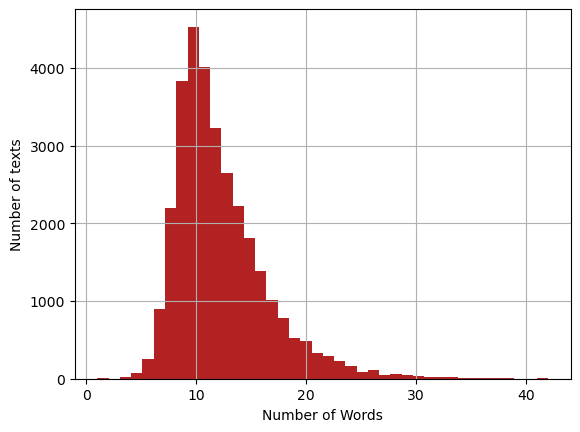

In [35]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [37]:

# Sample data
sample_data = ["Build fake news model.",
               "Using bert."]

# Tokenize
tokenized_sample_data = tokenizer(sample_data,
                                  padding=True,          # Pad sequences to same length
                                  truncation=True,       # Truncate long sequences
                                  return_tensors='pt')   # Return PyTorch tensors

print(tokenized_sample_data)


{'input_ids': tensor([[  101,  3857,  8275,  2739,  2944,  1012,   102],
        [  101,  2478, 14324,  1012,   102,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0, 0]])}


In [38]:
# Tokenize and encode sequences
tokens_train = tokenizer(
    train_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',   # pad sequences to max_length
    truncation=True,
    return_tensors='pt'     # directly returns PyTorch tensors
)

tokens_val = tokenizer(
    val_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

tokens_test = tokenizer(
    test_text.tolist(),
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)


In [39]:
# Convert labels to tensors
train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())


In [40]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32                                               #define a batch size


# Train DataLoader
train_data = TensorDataset(tokens_train['input_ids'], tokens_train['attention_mask'], train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Validation DataLoader
val_data = TensorDataset(tokens_val['input_ids'], tokens_val['attention_mask'], val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=BATCH_SIZE)

# Test DataLoader
test_data = TensorDataset(tokens_test['input_ids'], tokens_test['attention_mask'], test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)


### Freeze Layers

In [41]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

### Define Model Architecture

In [44]:
# Define classifier on top of BERT
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)         # dropout
        self.relu = nn.ReLU()                  # ReLU activation
        self.fc1 = nn.Linear(768, 512)         # dense layer 1
        self.fc2 = nn.Linear(512, 2)           # output layer for 2 classes
        self.softmax = nn.LogSoftmax(dim=1)    # softmax activation

    def forward(self, sent_id, mask):
        cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']  # [CLS] token representation
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


model = BERT_Arch(bert)
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
import torch
from torch.optim import AdamW   # use PyTorch's AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 2


### Define Train & Evaluate Function

In [45]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]                                  # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels)                         # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t for t in batch]                    # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels)          # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)         # compute the validation loss of the epoch
  return avg_loss

### Model training

In [46]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                       # train model
    valid_loss = evaluate()                    # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.566
Validation Loss: 0.496

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

### Model performance

In [52]:
# load weights of best model
path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [53]:
# Detect device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)          # move model to GPU (or CPU if no GPU)

all_preds = []
all_labels = []

model.eval()  # evaluation mode

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        
        # Move tensors to same device as model
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)
        
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())   # move predictions back to CPU for sklearn
        all_labels.extend(labels.cpu().numpy())

from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=['True', 'Fake']))


              precision    recall  f1-score   support

        True       0.77      0.93      0.84      3212
        Fake       0.92      0.75      0.83      3523

    accuracy                           0.84      6735
   macro avg       0.85      0.84      0.84      6735
weighted avg       0.85      0.84      0.83      6735



## Fake News Predictions

In [55]:
import torch
import numpy as np

# Make sure the model is in evaluation mode
model.eval()

# Example unseen news
unseen_news_text = [
    "Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",  # Fake
    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",        # True
    "Trump administration issues new rules on U.S. visa waivers"                        # True
]

# Tokenize and encode sequences
MAX_LENGTH = 15
tokens_unseen = tokenizer(
    unseen_news_text,
    max_length=MAX_LENGTH,
    padding='max_length',   # modern way instead of pad_to_max_length
    truncation=True,
    return_tensors='pt'     # directly returns PyTorch tensors
)

unseen_seq = tokens_unseen['input_ids']
unseen_mask = tokens_unseen['attention_mask']

# Move to GPU if needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
unseen_seq = unseen_seq.to(device)
unseen_mask = unseen_mask.to(device)

# Predict
with torch.no_grad():
    outputs = model(unseen_seq, unseen_mask)
    preds = torch.argmax(outputs, dim=1)  # get predicted class 0/1

# Convert to numpy array
preds = preds.cpu().numpy()
preds


array([1, 0, 0], dtype=int64)